<a href="https://colab.research.google.com/github/atlantiquesun/Stock_ML/blob/main/stock_arima_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



# 1. Data Exploration

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
Name: Sales, dtype: float64


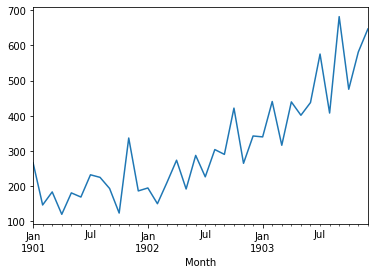

In [2]:
# load the dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')
 
series = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv", header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head(10)) #show the first 10 items
series.plot()
plt.show()

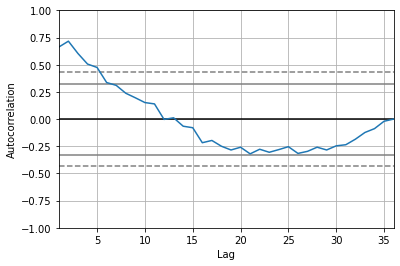

In [3]:
autocorrelation_plot(series)
plt.show()

# 2. ARIMA on Standard Dataset

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(36, 1) Index(['Sales'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,Sales
Month,
1901-01,266.0
1901-02,145.9
1901-03,183.1
1901-04,119.3
1901-05,180.3
1901-06,168.5
1901-07,231.8
1901-08,224.5
1901-09,192.8


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Thu, 19 Aug 2021   AIC                            406.340
Time:                        17:44:37   BIC                            417.227
Sample:                    02-28-1901   HQIC                           410.098
                         - 12-31-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

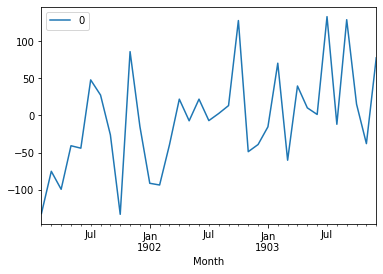

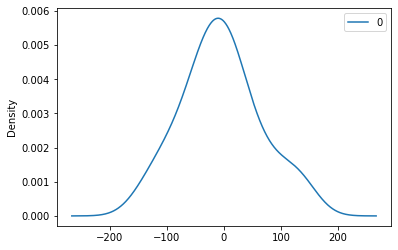

                0
count   35.000000
mean    -5.495223
std     68.132882
min   -133.296638
25%    -42.477902
50%     -7.186558
75%     24.748322
max    133.237947


In [4]:
from statsmodels.tsa.arima_model import ARIMA


# load the dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')
 
series = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv", header=0, parse_dates=[0], index_col=0, date_parser=parser)

series.index = series.index.to_period('M')
print(series.shape, series.columns)
display(series)

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


predicted=345.691945, expected=342.300000
predicted=305.082378, expected=339.700000
predicted=386.421663, expected=440.400000
predicted=348.546191, expected=315.900000
predicted=386.366688, expected=439.300000
predicted=355.288496, expected=401.300000
predicted=444.967336, expected=437.400000
predicted=393.170174, expected=575.500000
predicted=436.270447, expected=407.600000
predicted=507.796227, expected=682.000000
predicted=445.167787, expected=475.300000
predicted=655.825266, expected=581.300000
predicted=560.353739, expected=646.900000
Test RMSE: 82.523


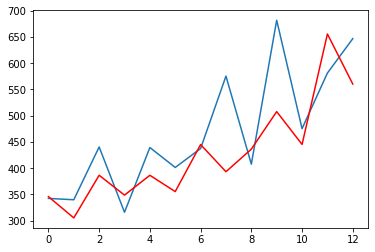

In [5]:
from statsmodels.tsa.arima_model import ARIMA


# load the dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')
 
series = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv", header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

series.index = series.index.to_period('M')

# split into train and test sets
X = series.values
size = int(len(X) * 0.66) #roughly 2/3
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(6,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# 3. ARIMA on Stock Data

In [11]:

def get_file_index(file_name):

    index = file_name.split(".")[0]
    start = 0
    while (start < len(index) and index[start] == "0"):
      start += 1
    return int(index[start:])

def make_multistep_dataset(df, features_column, steps=1):
  
  for i in range(steps):
    for feature in features_column:
      df[feature+"(t-"+str(i+1)+")"] = df[feature+"(t)"].shift(i+1)
  
  df = df.dropna()
  return df

def preprocess(df):

  #dropna
  df = df.dropna()
  #normalize
  #scaler = MinMaxScaler(feature_range=(0, 1))
  #df[df.columns] = scaler.fit_transform(df[df.columns])
  return df

def load_data(n_stocks, steps):
  columns = ["open(t)", "close(t)", "high(t)", "low(t)"]
  data_folder = "/content/drive/MyDrive/StockML /processed_data"
  files = os.listdir(data_folder)
  files.sort(key = lambda x: get_file_index(x))


  df = None
  for i in range(n_stocks):
    
    # get file name
    file = files[i]

    # load data
    df_temp = pd.read_csv(data_folder+"/"+file, names=columns)

    # preprocess data
    df_temp = preprocess(df_temp)

    # make multistep dataset
    features_column = [x[:-3] for x in columns]
    df_temp = make_multistep_dataset(df_temp, features_column, steps)
    df_temp = df_temp.dropna()
    df_temp['time_index'] = df_temp.index #keep the original timestep index of each record

    #concatenate with df
    if (i==0):
      df = df_temp
    else:
      df = pd.concat([df, df_temp])

    # make sure the index is correct
    df = df.reset_index(drop = True)

  return df


In [12]:
n_stocks = 1
steps = 0
df = load_data(n_stocks, steps)
df = df.drop("time_index", axis=1)
display(df)

,open(t),close(t),high(t),low(t)
0,21.55,22.31,22.42,21.26
1,22.13,22.20,23.14,22.13
2,22.14,22.90,23.29,22.14
3,22.60,22.63,23.00,22.27
4,22.63,22.91,23.36,22.53
...,...,...,...,...
125,17.64,18.01,18.14,17.18
126,17.99,17.89,18.15,17.66
127,18.04,17.81,18.07,17.60
128,17.70,17.68,18.05,17.58


predicted=23.862189, expected=24.540000
predicted=24.521350, expected=24.300000
predicted=24.440176, expected=24.530000
predicted=24.479467, expected=24.650000
predicted=24.608578, expected=24.200000
predicted=24.281441, expected=23.370000
predicted=23.423517, expected=23.220000
predicted=23.183676, expected=23.260000
predicted=23.363318, expected=23.100000
predicted=23.270887, expected=22.650000
predicted=22.740475, expected=22.160000
predicted=22.173350, expected=22.970000
predicted=22.902191, expected=23.140000
predicted=23.266934, expected=23.080000
predicted=23.117325, expected=23.360000
predicted=23.266760, expected=22.780000
predicted=22.821891, expected=22.340000
predicted=22.332453, expected=22.620000
predicted=22.573303, expected=23.200000
predicted=23.248322, expected=21.810000
predicted=22.053411, expected=22.060000
predicted=21.967749, expected=22.780000
predicted=22.667517, expected=22.550000
predicted=22.632256, expected=21.510000
predicted=21.737275, expected=21.270000


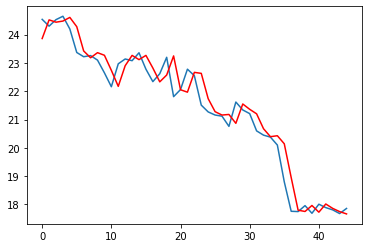

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# split into train and test sets
X = df["close(t)"].values
size = int(len(X) * 0.66) #roughly 2/3
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()